# Particle movement in a simple model of a tokamak

In [5]:
%load_ext autoreload
%autoreload 2
from plasmapy import simulation
from plasmapy.formulary import magnetostatics
from plasmapy.classes.sources import Coils
import astropy.units as u
import numpy as np
radius = 1 * u.m
main_current = 15 * u.MA
plasma_wire = magnetostatics.CircularWire([0, 0, 1], u.Quantity((0, 0, 0), u.m), radius, main_current)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's visualize this coil using the awesome `mayavi` library.

Some pointers on installing it:

In [6]:
from mayavi import mlab
mlab.init_notebook()
plasma_wire.visualize()

Notebook initialized with ipy backend.


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x01^\x08\x02\x00\x00\x00$?\xde_\x00\…

That's supposed to model just the plasma; let's add a few coils:

In [7]:
n_coils = 8
currents = u.Quantity(n_coils * [10], u.MA)

coil_angles = np.linspace(0, 2*np.pi, n_coils, endpoint=False)
coil_angles
minor_radius = 0.3 * u.m

coils = []
for i in range(n_coils):
    coil_angle = coil_angles[i]
    x = radius * np.cos(coil_angle)
    y = radius * np.sin(coil_angle)
    normal_angle = np.pi/2 + coil_angle
    normal = u.Quantity([np.cos(normal_angle), np.sin(normal_angle), 0])
    center = u.Quantity([x, y, 0 * u.m])
    coil = magnetostatics.CircularWire(normal, center, minor_radius, currents[i])
    coils.append(coil)
all_currents = coils + [plasma_wire]
c = Coils(*all_currents)
c.visualize()

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x01^\x08\x02\x00\x00\x00$?\xde_\x00\…

In [8]:
# from plasmapy import formulary

# r = np.array([[0, 0, 1.1]], dtype=float)
# optimizable = lambda r: 1/20/formulary.gyrofrequency(np.linalg.norm(c._interpolate_B(r)), 'e-', to_hz = True)
# from scipy import optimize

# optimize.minimize(optimizable, r).fun

In [9]:
x = u.Quantity([[1 + minor_radius.si.value / 2, 0, 0]],  u.m)
v = u.Quantity([[0, 10000, 100]], u.m / u.s)

sim = simulation.ParticleTracker(c, x, v, 'e',)
solution = sim.run(1e-7 * u.s, 1e4)
solution._velocity_history[:,0,:]

array([[ 6.81784598e-02,  5.64767074e+03, -8.25310943e+03],
       [ 2.89166961e+01,  9.99995684e+03,  1.00135164e+02],
       [ 4.90531750e+01,  5.64805841e+03, -8.25269835e+03],
       ...,
       [ 4.25646929e+03,  6.31846897e+03,  6.47838090e+03],
       [-4.00903407e+03, -4.49203985e+03, -7.98493731e+03],
       [ 4.26229989e+03,  6.32981606e+03,  6.46345328e+03]])

In [10]:
fig = mlab.figure(size=(800, 600))
c.visualize(fig)
solution.visualize(fig)
mlab.orientation_axes(figure=fig)
fig

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03 \x00\x00\x02X\x08\x02\x00\x00\x00\x15\x14\x15\'\…

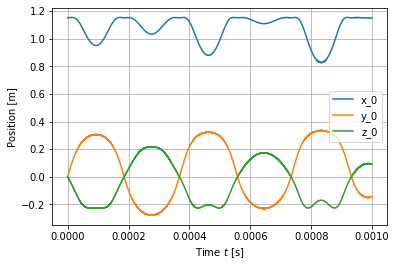

In [11]:
solution.plot_time_trajectories()

In [ ]:
solution2 = sim.run(1e-8 * u.s, int(1e5))

fig = mlab.figure(size=(800, 600))
c.visualize(fig)
solution2.visualize(fig)
mlab.orientation_axes(figure=fig)
fig

In [ ]:
x = u.Quantity([[1 + minor_radius.si.value / 2, 0, 0]],  u.m)
v = u.Quantity([[10000, 10000, 1000000]], u.m / u.s)

banana_sim = simulation.ParticleTracker(c, x, v, 'e',)
banana_solution = banana_sim.run(1e-8 * u.s, 1e4)
banana_solution.plot_time_trajectories()
fig = mlab.figure(size=(800, 600))
c.visualize(fig)
banana_solution.visualize(fig)
mlab.orientation_axes(figure=fig)
fig

In [ ]:
dir(mlab)

In [ ]:
solution2 = sim.run(1e-7 * u.s, int(3e4))

fig = mlab.figure(size=(800, 600))
c.visualize(fig)
solution2.visualize(fig)
mlab.orientation_axes(figure=fig)
fig

In [ ]:
solution2_unstable = sim.run(1e-5 * u.s, int(3e2))

fig = mlab.figure()
c.visualize(fig)
solution2_unstable.visualize(fig)
mlab.orientation_axes(figure=fig)
fig

In [ ]:
x2 = u.Quantity([[1 + minor_radius.si.value / 2, 0, 0]],  u.m)
v2 = u.Quantity([[0, 10000, 0]], u.m / u.s)

sim2 = simulation.ParticleTracker(c, x2, v2, 'e', )
solution3 = sim.run(1e-8 * u.s, int(3e5))

fig2 = mlab.figure()
c.visualize(fig2)
solution3.visualize(fig2)
mlab.orientation_axes(figure=fig2)
display(fig2)

In [ ]:
solution3.plot_time_trajectories('xy') # TODO fix labels - they're showing up as units!

In [ ]:
factor = 1.7
x = np.linspace(-factor * (radius + minor_radius), factor * (radius + minor_radius), 100)
z = np.linspace(-2*factor * minor_radius, 2*factor * minor_radius, 100)
X, Y, Z = np.meshgrid(x, x, z, indexing='ij')

Bval = np.zeros((3, *Z.shape))

from tqdm import auto as tqdm

for i, xi in tqdm.tqdm(enumerate(x.si.value), total=len(x)):
    for j, yi in enumerate(x.si.value):
        for k, zi in enumerate(z.si.value):
            pos = np.array([[xi, yi, zi]])
            field = c._interpolate_B(pos)
            Bval[:, i,j,k] = field

Bmag2 = np.sum(Bval**2, axis=0)


# In[70]:


fig = mlab.figure(size=(800, 600))
c.visualize(fig)

contours = mlab.contour3d(X.value, Y.value, Z.value, np.log10(Bmag2), figure=fig,
#                           contours = np.linspace(Bmag2.min(), Bmag2.max(), 50).tolist(),
#                           contours = np.logspace(np.log10(Bmag2.min()),
#                                                  np.log10(Bmag2.max()),
#                                                  num=10,
#                                                 ).tolist(),
                          contours = 15,
                          opacity = 0.3,
                         )
mlab.colorbar(contours, title="log10 |B|^2")
mlab.orientation_axes(figure=fig)
solution3.visualize(fig2)
display(fig)

# TODO units in reprs for MagnetoStatics

# TODO MagnetoStatics.magnetic_field accepts no units, just numpy arrays!

# TODO mendeleev vs atomic - comparison

# TODO Automatically generate unit-less wrappers for Astropy units